In [1]:
!cd /home/ir739wb/ilyarekun/bc_project/federated-learning/fed-avg-code



In [2]:
import os
import flwr as fl
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
import numpy as np
import kagglehub
import shutil
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from flwr.common import parameters_to_ndarrays

# Set seeds for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda:0


In [3]:
class BrainCNN(nn.Module):
    def __init__(self):
        super(BrainCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.45),
            nn.Conv2d(64, 128, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.45),
            nn.Conv2d(128, 128, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout2d(p=0.45),
            nn.Conv2d(128, 256, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.45),
            nn.Conv2d(256, 256, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            nn.Dropout2d(p=0.4),
            nn.Conv2d(256, 512, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.4)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 3 * 3, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(512, 4),
        )
        
    def forward(self, x):
        out = self.conv_layers(x)
        out = out.view(out.size(0), -1)  # Flatten
        out = self.fc_layers(out)
        return out

In [4]:
""" class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state) """

' class EarlyStopping:\n    def __init__(self, patience=5, delta=0):\n        self.patience = patience\n        self.delta = delta\n        self.best_score = None\n        self.early_stop = False\n        self.counter = 0\n        self.best_model_state = None\n\n    def __call__(self, val_loss, model):\n        score = -val_loss\n\n        if self.best_score is None:\n            self.best_score = score\n            self.best_model_state = model.state_dict()\n        elif score < self.best_score + self.delta:\n            self.counter += 1\n            if self.counter >= self.patience:\n                self.early_stop = True\n        else:\n            self.best_score = score\n            self.best_model_state = model.state_dict()\n            self.counter = 0\n\n    def load_best_model(self, model):\n        model.load_state_dict(self.best_model_state) '

In [5]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, threshold=0.19):
        self.patience = patience
        self.delta = delta
        self.threshold = threshold
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        # Если достигнут порог, останавливаем немедленно.
        if val_loss <= self.threshold:
            print(f"Val loss {val_loss:.5f} ниже порогового значения {self.threshold}.")
            self.early_stop = True
            self.best_model_state = model.state_dict()
            return

        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)


In [6]:
def data_preprocessing_tumor_IID(num_clients=4):
    dataset_path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
    train_path = os.path.join(dataset_path, "Training")
    test_path = os.path.join(dataset_path, "Testing")
    general_dataset_path = os.path.join(dataset_path, "General_Dataset")
    os.makedirs(general_dataset_path, exist_ok=True)
    
    for source_path in [train_path, test_path]:
        for class_name in os.listdir(source_path):
            class_path = os.path.join(source_path, class_name)
            general_class_path = os.path.join(general_dataset_path, class_name)
            os.makedirs(general_class_path, exist_ok=True)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                shutil.move(img_path, os.path.join(general_class_path, img_name))
    
    transform = transforms.Compose([
        transforms.CenterCrop((400, 400)),
        transforms.Resize((200, 200)),
        transforms.ToTensor(),
    ])
    
    general_dataset = ImageFolder(root=general_dataset_path, transform=transform)
    targets = general_dataset.targets
    classes = list(set(targets))
    
    train_indices = []
    val_indices = []
    test_indices = []
    train_ratio = 0.7
    val_ratio = 0.2
    test_ratio = 0.1
    
    for class_label in classes:
        class_indices = [i for i, target in enumerate(targets) if target == class_label]
        class_size = len(class_indices)
        train_size = int(train_ratio * class_size)
        val_size = int(val_ratio * class_size)
        test_size = class_size - train_size - val_size
        train_indices.extend(class_indices[:train_size])
        val_indices.extend(class_indices[train_size:train_size + val_size])
        test_indices.extend(class_indices[train_size + val_size:])
    
    train_set = Subset(general_dataset, train_indices)
    val_set = Subset(general_dataset, val_indices)
    test_set = Subset(general_dataset, test_indices)
    
    val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=64, shuffle=False)
    
    client_indices = {client: [] for client in range(num_clients)}
    for class_label in classes:
        class_train_indices = [idx for idx in train_indices if general_dataset.targets[idx] == class_label]
        np.random.shuffle(class_train_indices)
        splits = np.array_split(class_train_indices, num_clients)
        for client in range(num_clients):
            client_indices[client].extend(splits[client].tolist())
    
    client_train_loaders = []
    for client in range(num_clients):
        subset = Subset(general_dataset, client_indices[client])
        loader = DataLoader(subset, batch_size=64, shuffle=True)
        client_train_loaders.append(loader)
    
    return client_train_loaders, val_loader, test_loader

# Compute data loaders for 4 clients
#client_train_loaders, val_loader, test_loader = data_preprocessing_tumor_IID(num_clients=4)



In [7]:
def data_preprocessing_tumor_NON_IID(num_clients=4):
    # Download and prepare the dataset
    dataset_path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
    train_path = os.path.join(dataset_path, "Training")
    test_path = os.path.join(dataset_path, "Testing")
    general_dataset_path = os.path.join(dataset_path, "General_Dataset")
    os.makedirs(general_dataset_path, exist_ok=True)
    
    # Merge Training and Testing folders into a single General_Dataset folder by class
    for source_path in [train_path, test_path]:
        for class_name in os.listdir(source_path):
            class_path = os.path.join(source_path, class_name)
            general_class_path = os.path.join(general_dataset_path, class_name)
            os.makedirs(general_class_path, exist_ok=True)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                shutil.move(img_path, os.path.join(general_class_path, img_name))
    
    # Define image transformations
    transform = transforms.Compose([
        transforms.CenterCrop((400, 400)),
        transforms.Resize((200, 200)),
        transforms.ToTensor(),
    ])
    
    # Create the PyTorch dataset from the general dataset folder
    general_dataset = ImageFolder(root=general_dataset_path, transform=transform)
    targets = general_dataset.targets
    classes = list(set(targets))
    
    # Split indices into train/validation/test sets (stratified by class)
    train_indices = []
    val_indices = []
    test_indices = []
    train_ratio = 0.7
    val_ratio = 0.2
    # test_ratio will be the remainder (0.1)
    
    for class_label in classes:
        class_indices = [i for i, target in enumerate(targets) if target == class_label]
        class_size = len(class_indices)
        train_size = int(train_ratio * class_size)
        val_size = int(val_ratio * class_size)
        # Assign the first portion for training, next for validation, rest for test
        train_indices.extend(class_indices[:train_size])
        val_indices.extend(class_indices[train_size:train_size + val_size])
        test_indices.extend(class_indices[train_size + val_size:])
    
    # Create subsets and dataloaders for validation and test sets
    train_set = Subset(general_dataset, train_indices)
    val_set = Subset(general_dataset, val_indices)
    test_set = Subset(general_dataset, test_indices)
    
    val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=64, shuffle=False)
    
    # ===== Non-IID Train Data Partitioning =====
    # Distribution table (for 4 classes and 4 clients):
    # For class 0: client0:70%, client1:15%, client2:10%, client3:5%
    # For class 1: client0:15%, client1:70%, client2:10%, client3:5%
    # For class 2: client0:10%, client1:15%, client2:70%, client3:5%
    # For class 3: client0:5%,  client1:10%, client2:15%, client3:70%
    # The keys are class labels and each value is a list of percentages for each client.
    distribution = {
        0: [0.70, 0.15, 0.10, 0.05],
        1: [0.15, 0.70, 0.10, 0.05],
        2: [0.10, 0.15, 0.70, 0.05],
        3: [0.05, 0.10, 0.15, 0.70]
    }
    
    # Initialize a dictionary to hold the train indices for each client
    client_indices = {client: [] for client in range(num_clients)}
    
    # For each class, distribute the training samples among clients according to the distribution
    for class_label in classes:
        # Get all training indices for the given class
        class_train_indices = [idx for idx in train_indices if general_dataset.targets[idx] == class_label]
        np.random.shuffle(class_train_indices)
        
        n = len(class_train_indices)
        # Compute allocation counts for each client for this class
        allocation = []
        for client in range(num_clients):
            cnt = int(distribution[class_label][client] * n)
            allocation.append(cnt)
        # Adjust the last client allocation to account for rounding errors
        allocation[-1] = n - sum(allocation[:-1])
        
        start = 0
        for client in range(num_clients):
            cnt = allocation[client]
            client_indices[client].extend(class_train_indices[start:start + cnt])
            start += cnt
    
    # Create DataLoaders for each client's training subset
    client_train_loaders = []
    for client in range(num_clients):
        subset = Subset(general_dataset, client_indices[client])
        loader = DataLoader(subset, batch_size=64, shuffle=True)
        client_train_loaders.append(loader)
    
    return client_train_loaders, val_loader, test_loader

# Compute data loaders for 4 clients
client_train_loaders, val_loader, test_loader = data_preprocessing_tumor_NON_IID(num_clients=4)
""" print(f"Train datasets size:")
for loadrr in client_train_loaders:
    print(f"Train loader {loadrr} size: {len(loadrr.dataset)}")

print(f"Validation dataset size: {len(val_loader.dataset)}")
print(f"Test dataset size: {len(test_loader.dataset)}") """


' print(f"Train datasets size:")\nfor loadrr in client_train_loaders:\n    print(f"Train loader {loadrr} size: {len(loadrr.dataset)}")\n\nprint(f"Validation dataset size: {len(val_loader.dataset)}")\nprint(f"Test dataset size: {len(test_loader.dataset)}") '

In [8]:
import numpy as np

# Define class names for readability
class_names = {
    0: 'Glioma',
    1: 'Meningioma',
    2: 'No tumor',
    3: 'Pituitary'
}

# Compute data loaders for 4 clients (use either IID or Non-IID function)
# For Non-IID:
#client_train_loaders, val_loader, test_loader = data_preprocessing_tumor_NON_IID(num_clients=4)
# For IID, replace with:
# client_train_loaders, val_loader, test_loader = data_preprocessing_tumor_IID(num_clients=4)

# Print training datasets' sizes and class distributions
print("Train datasets class distributions:")
for i, loader in enumerate(client_train_loaders):
    subset = loader.dataset  # The Subset object for this client's data
    original_dataset = subset.dataset  # The original dataset (e.g., ImageFolder)
    indices = subset.indices  # Indices of samples assigned to this client
    targets = np.array(original_dataset.targets)  # Convert targets to NumPy array
    client_labels = targets[indices]  # Extract labels for this client's subset
    label_counts = np.bincount(client_labels, minlength=4)  # Count each class (0-3)
    
    print(f"Client {i+1} training data:")
    print(f"  Total size: {len(client_labels)} images")
    for label in range(4):
        count = label_counts[label]
        class_name = class_names[label]
        print(f"  {class_name}: {count} images")
    print()

# Print validation dataset size and class distribution
print("Validation dataset class distribution:")
val_subset = val_loader.dataset
val_original_dataset = val_subset.dataset
val_indices = val_subset.indices
val_targets = np.array(val_original_dataset.targets)
val_labels = val_targets[val_indices]
val_label_counts = np.bincount(val_labels, minlength=4)

print(f"  Total size: {len(val_labels)} images")
for label in range(4):
    count = val_label_counts[label]
    class_name = class_names[label]
    print(f"  {class_name}: {count} images")
print()

# Print test dataset size and class distribution
print("Test dataset class distribution:")
test_subset = test_loader.dataset
test_original_dataset = test_subset.dataset
test_indices = test_subset.indices
test_targets = np.array(test_original_dataset.targets)
test_labels = test_targets[test_indices]
test_label_counts = np.bincount(test_labels, minlength=4)

print(f"  Total size: {len(test_labels)} images")
for label in range(4):
    count = test_label_counts[label]
    class_name = class_names[label]
    print(f"  {class_name}: {count} images")

Train datasets class distributions:
Client 1 training data:
  Total size: 1166 images
  Glioma: 793 images
  Meningioma: 172 images
  No tumor: 140 images
  Pituitary: 61 images

Client 2 training data:
  Total size: 1307 images
  Glioma: 170 images
  Meningioma: 805 images
  No tumor: 210 images
  Pituitary: 122 images

Client 3 training data:
  Total size: 1391 images
  Glioma: 113 images
  Meningioma: 115 images
  No tumor: 979 images
  Pituitary: 184 images

Client 4 training data:
  Total size: 1050 images
  Glioma: 58 images
  Meningioma: 59 images
  No tumor: 71 images
  Pituitary: 862 images

Validation dataset class distribution:
  Total size: 1404 images
  Glioma: 324 images
  Meningioma: 329 images
  No tumor: 400 images
  Pituitary: 351 images

Test dataset class distribution:
  Total size: 705 images
  Glioma: 163 images
  Meningioma: 165 images
  No tumor: 200 images
  Pituitary: 177 images


In [9]:
def get_model():
    return BrainCNN().to(device)

def get_optimizer(model):
    """
    _: lr = 0.001, weight_decay=0.001
    """
    #return optim.SGD(model.parameters(), lr=0.0008, momentum=0.9, weight_decay=0.09)
    #return optim.SGD(model.parameters(), lr=0.0007, momentum=0.9, weight_decay=0.09)
    #return optim.SGD(model.parameters(), lr=0.0009, momentum=0.9, weight_decay=0.05)
    #return optim.SGD(model.parameters(), lr=0.0009, momentum=0.8, weight_decay=0.07)
    #return optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.09) - 1
    return optim.SGD(model.parameters(), lr=0.001, momentum=0.6, weight_decay=0.09)



    
def get_loss_function():
    return nn.CrossEntropyLoss()

def fit_config(server_round: int):
    return {"local_epochs": 5}  # 5 local epochs per client per round

def evaluate_fn(server_round, parameters, config):
    model = get_model()
    state_dict = {k: torch.tensor(v) for k, v in zip(model.state_dict().keys(), parameters)}
    model.load_state_dict(state_dict)
    model.eval()
    
    criterion = get_loss_function()
    val_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    val_loss /= len(val_loader.dataset)
    accuracy = (np.array(all_preds) == np.array(all_targets)).mean()
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='macro', zero_division=0
    )
    
    return val_loss, {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [10]:
from flwr.common import Context

def client_fn(context: Context):
    # Extract client ID from context
    #cid = context.node_config["cid"]
    #cid = context.node_id
    cid = int(context.node_id) % len(client_train_loaders)

    
    # Initialize model, optimizer, and loss function
    model = BrainCNN().to(device)
    optimizer = get_optimizer(model)
    criterion = get_loss_function()
    train_loader = client_train_loaders[int(cid)]
    
    class FlowerClient(fl.client.NumPyClient):
        def get_parameters(self, config):
            return [val.cpu().numpy() for _, val in model.state_dict().items()]
        
        def fit(self, parameters, config):
            # Load parameters into the model
            state_dict = {k: torch.tensor(v) for k, v in zip(model.state_dict().keys(), parameters)}
            model.load_state_dict(state_dict)
            model.train()
            for _ in range(config["local_epochs"]):
                for data, target in train_loader:
                    data, target = data.to(device), target.to(device)
                    optimizer.zero_grad()
                    output = model(data)
                    loss = criterion(output, target)
                    loss.backward()
                    optimizer.step()
            return self.get_parameters(config), len(train_loader.dataset), {}
        
        def evaluate(self, parameters, config):
            # Load parameters into the model
            state_dict = {k: torch.tensor(v) for k, v in zip(model.state_dict().keys(), parameters)}
            model.load_state_dict(state_dict)
            model.eval()
            loss = 0.0
            num_examples = 0
            with torch.no_grad():
                for data, target in train_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss += criterion(output, target).item()
                    num_examples += data.size(0)  # Count number of examples in batch
            # Compute average loss and return as a tuple with 3 elements
            avg_loss = loss / len(train_loader) if len(train_loader) > 0 else 0.0
            metrics = {"accuracy": 0.0}  # Placeholder; replace with actual accuracy if computed
            return avg_loss, num_examples, metrics
    
    return FlowerClient().to_client()  # Return Flower Client object

In [ ]:
class CustomFedAvg(fl.server.strategy.FedAvg):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.metrics_history = {
            "val_loss": [],
            "accuracy": [],
            "precision": [],
            "recall": [],
            "f1": []
        }
        self.final_parameters = None
        #self.early_stopping = EarlyStopping(patience=100, delta=0.002)
        #self.early_stopping = EarlyStopping(patience=5, delta=0, threshold=0.19) - 1
        self.early_stopping = EarlyStopping(patience=40, delta=0.00001, threshold=0.0001)
    
    """ def evaluate(self, server_round, parameters):
        result = super().evaluate(server_round, parameters)
        if result:
            loss, metrics = result
            self.metrics_history["val_loss"].append(loss)
            for key in metrics:
                self.metrics_history[key].append(metrics[key])
            self.final_parameters = parameters  # Store the latest parameters
        return result """
    
    
    def evaluate(self, server_round, parameters):
        result = super().evaluate(server_round, parameters)
        if result:
            loss, metrics = result
            self.metrics_history["val_loss"].append(loss)
            for key in metrics:
                self.metrics_history[key].append(metrics[key])
            self.final_parameters = parameters  # сохраняем текущие параметры
            
            # Создаем глобальную модель и загружаем в неё параметры
            global_model = get_model()  # get_model() – функция, возвращающая новый экземпляр модели
            # Преобразуем параметры Flower в numpy-массивы и создаем state_dict
            final_ndarrays = parameters_to_ndarrays(parameters)
            state_dict = {
                k: torch.tensor(v)
                for k, v in zip(global_model.state_dict().keys(), final_ndarrays)
            }
            global_model.load_state_dict(state_dict)
            
            # Вызываем early stopping с текущим значением loss и моделью
            self.early_stopping(loss, global_model)
            if self.early_stopping.early_stop:
                print(f"Ранняя остановка сработала на раунде {server_round}.")
                # Дополнительно можно сохранить best_model_state, преобразовав его в параметры
                best_state_dict = self.early_stopping.best_model_state
                # Преобразуем state_dict в список numpy-матриц (в том же порядке, что и в модели)
                best_parameters = [
                    best_state_dict[k].cpu().numpy() for k in global_model.state_dict().keys()
                ]
                self.final_parameters = best_parameters
                # Останавливаем обучение, выбрасывая исключение
                raise StopIteration("Early stopping triggered.")
        return result

strategy = CustomFedAvg(
    fraction_fit=1.0,
    min_fit_clients=4,
    min_available_clients=4,
    evaluate_fn=evaluate_fn,
    on_fit_config_fn=fit_config
)

In [ ]:
try:
    history = fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=4,
        config=fl.server.ServerConfig(num_rounds=40),
        strategy=strategy,
        client_resources={"num_cpus": 2, "num_gpus": 0.5},
        ray_init_args={
            "num_cpus": 16,
            "object_store_memory": 40 * 1024**3
        }
    )
except StopIteration as e:
    print(e)
print("Federated learning simulation completed.")


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=40, no round_timeout


2025-04-10 22:52:15,167	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'accelerator_type:A100': 1.0, 'node:__internal_head__': 1.0, 'CPU': 16.0, 'memory': 955401845760.0, 'object_store_memory': 42949672960.0, 'node:147.232.100.130': 1.0, 'GPU': 2.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 0.5}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 4 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 1.3866366158183823, {'accuracy': np.float64(0.23433048433048434), 'precision': 0.058582621082621085, 'recall': 0.25, 'f1': 0.09492210040392383

KeyboardInterrupt: 

*** SIGTERM received at time=1744318421 on cpu 7 ***
PC: @     0x79ef47e98d71  (unknown)  (unknown)
    @     0x79ef47e45330  (unknown)  (unknown)
    @     0x79ef47ea4fb8         96  (unknown)
    @           0x504fac  (unknown)  PyThread_acquire_lock_timed
[2025-04-10 22:53:41,090 E 292425 292425] logging.cc:440: *** SIGTERM received at time=1744318421 on cpu 7 ***
[2025-04-10 22:53:41,091 E 292425 292425] logging.cc:440: PC: @     0x79ef47e98d71  (unknown)  (unknown)
[2025-04-10 22:53:41,091 E 292425 292425] logging.cc:440:     @     0x79ef47e45330  (unknown)  (unknown)
[2025-04-10 22:53:41,091 E 292425 292425] logging.cc:440:     @     0x79ef47ea4fb8         96  (unknown)
[2025-04-10 22:53:41,091 E 292425 292425] logging.cc:440:     @           0x504fac  (unknown)  PyThread_acquire_lock_timed


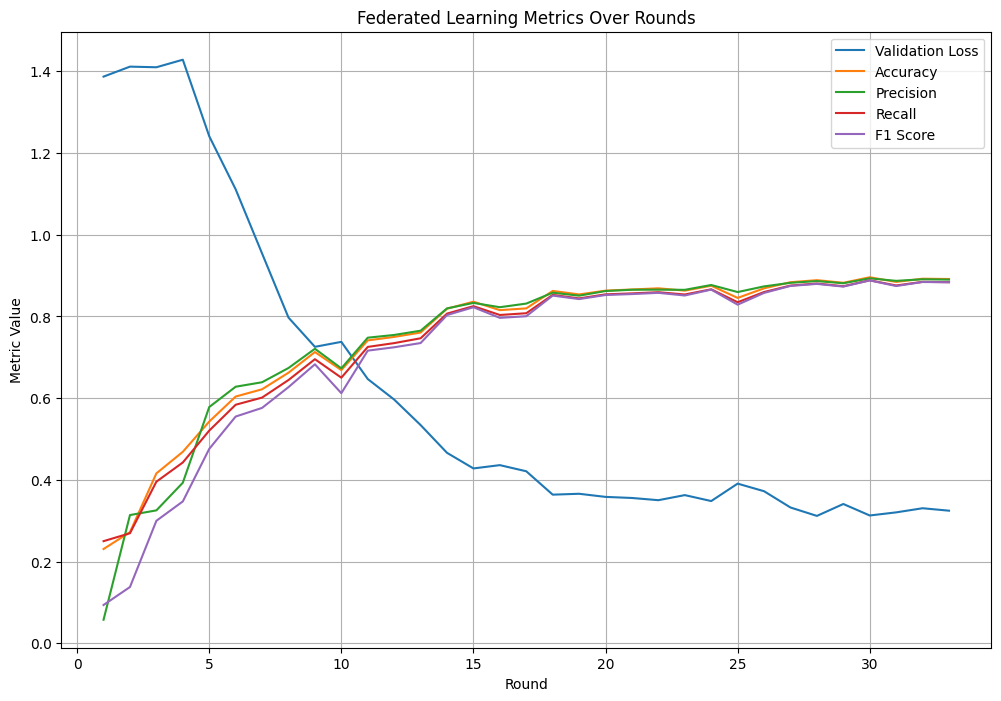

In [ ]:
rounds = range(1, len(strategy.metrics_history['accuracy']) + 1)
plt.figure(figsize=(12, 8))
plt.plot(rounds, strategy.metrics_history['val_loss'], label='Validation Loss')
plt.plot(rounds, strategy.metrics_history['accuracy'], label='Accuracy')
plt.plot(rounds, strategy.metrics_history['precision'], label='Precision')
plt.plot(rounds, strategy.metrics_history['recall'], label='Recall')
plt.plot(rounds, strategy.metrics_history['f1'], label='F1 Score')
plt.xlabel('Round')
plt.ylabel('Metric Value')
plt.title('Federated Learning Metrics Over Rounds')
plt.legend()
plt.grid(True)

# Сначала сохранить
plt.savefig('/home/ir739wb/ilyarekun/bc_project/federated-learning/fed-avg-code/fed-avg-non-iid-graph2.png', dpi=300)

# Потом показать (если нужно)
plt.show()

# И только после этого закрыть
plt.close()


In [ ]:
""" from flwr.common import parameters_to_ndarrays

model = get_model()

# Convert the Flower Parameters to a list of NumPy arrays
final_ndarrays = parameters_to_ndarrays(strategy.final_parameters)

# Create a state dictionary mapping each key to a torch tensor of the corresponding parameter array
state_dict = {k: torch.tensor(v) for k, v in zip(model.state_dict().keys(), final_ndarrays)}
model.load_state_dict(state_dict)
model.eval()

all_preds = []
all_targets = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

accuracy = (np.array(all_preds) == np.array(all_targets)).mean()
precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_preds, average='macro')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")
 """

Test Accuracy: 0.9291
Test Precision: 0.9260
Test Recall: 0.9257
Test F1 Score: 0.9253


In [ ]:
from flwr.common import parameters_to_ndarrays
import torch
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# Determine which parameters to use based on early stopping
if strategy.early_stopping.early_stop:
    print("Using the best model parameters from early stopping.")
    best_parameters = strategy.final_parameters
else:
    print("Early stopping was not triggered. Using the final round's parameters.")
    best_parameters = strategy.final_parameters

# Create a new model instance
model = get_model()  # Assumes get_model() returns BrainCNN().to(device)

# Convert the Flower Parameters to a list of NumPy arrays
final_ndarrays = (best_parameters)

# Create a state dictionary mapping each key to a torch tensor
state_dict = {k: torch.tensor(v) for k, v in zip(model.state_dict().keys(), final_ndarrays)}

# Load the state dictionary into the model
model.load_state_dict(state_dict)
model.eval()

# Evaluate the model on the test set
all_preds = []
all_targets = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Compute metrics
accuracy = (np.array(all_preds) == np.array(all_targets)).mean()
precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_preds, average='macro', zero_division=0)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# Save metrics to file
metrics_file = '/home/ir739wb/ilyarekun/bc_project/federated-learning/fed-avg-code/fed-avg-non-iid-metrics2.txt'
with open(metrics_file, 'w') as f:
    rounds = range(1, len(strategy.metrics_history['val_loss']) + 1)
    for round_num in rounds:
        f.write(f"Round {round_num}:\n")
        f.write(f"  Validation Loss: {strategy.metrics_history['val_loss'][round_num-1]:.4f}\n")
        f.write(f"  Accuracy: {strategy.metrics_history['accuracy'][round_num-1]:.4f}\n")
        f.write(f"  Precision: {strategy.metrics_history['precision'][round_num-1]:.4f}\n")
        f.write(f"  Recall: {strategy.metrics_history['recall'][round_num-1]:.4f}\n")
        f.write(f"  F1 Score: {strategy.metrics_history['f1'][round_num-1]:.4f}\n")
    f.write("\nTest Metrics:\n")
    f.write(f"  Accuracy: {accuracy:.4f}\n")
    f.write(f"  Precision: {precision:.4f}\n")
    f.write(f"  Recall: {recall:.4f}\n")
    f.write(f"  F1 Score: {f1:.4f}\n")
print(f"Metrics saved to '{metrics_file}'")

Using the best model parameters from early stopping.
Test Accuracy: 0.8681
Test Precision: 0.8600
Test Recall: 0.8580
Test F1 Score: 0.8555
Metrics saved to '/home/ir739wb/ilyarekun/bc_project/federated-learning/fed-avg-code/fed-avg-non-iid-metrics1.txt'


*** SIGTERM received at time=1744318311 on cpu 5 ***
PC: @     0x7f985f52a042  (unknown)  epoll_wait
    @     0x7f985f445330  (unknown)  (unknown)
    @     0x7f985e7a8883  (unknown)  select_epoll_poll
[2025-04-10 22:51:51,438 E 4176097 4176097] logging.cc:440: *** SIGTERM received at time=1744318311 on cpu 5 ***
[2025-04-10 22:51:51,438 E 4176097 4176097] logging.cc:440: PC: @     0x7f985f52a042  (unknown)  epoll_wait
[2025-04-10 22:51:51,438 E 4176097 4176097] logging.cc:440:     @     0x7f985f445330  (unknown)  (unknown)
[2025-04-10 22:51:51,438 E 4176097 4176097] logging.cc:440:     @     0x7f985e7a8883  (unknown)  select_epoll_poll


In [ ]:
""" with open('/home/ir739wb/ilyarekun/bc_project/federated-learning/fed-avg-code/fed-avg-non-iid-metrics1.txt', 'w') as f:
    for round_num in rounds:
        f.write(f"Round {round_num}:\n")
        f.write(f"  Validation Loss: {strategy.metrics_history['val_loss'][round_num-1]:.4f}\n")
        f.write(f"  Accuracy: {strategy.metrics_history['accuracy'][round_num-1]:.4f}\n")
        f.write(f"  Precision: {strategy.metrics_history['precision'][round_num-1]:.4f}\n")
        f.write(f"  Recall: {strategy.metrics_history['recall'][round_num-1]:.4f}\n")
        f.write(f"  F1 Score: {strategy.metrics_history['f1'][round_num-1]:.4f}\n")
    f.write("\nTest Metrics:\n")
    f.write(f"  Accuracy: {accuracy:.4f}\n")
    f.write(f"  Precision: {precision:.4f}\n")
    f.write(f"  Recall: {recall:.4f}\n")
    f.write(f"  F1 Score: {f1:.4f}\n")
print("Metrics saved to 'fed-avg-iid-metrics2.txt'") """

Metrics saved to 'fed-avg-iid-metrics2.txt'


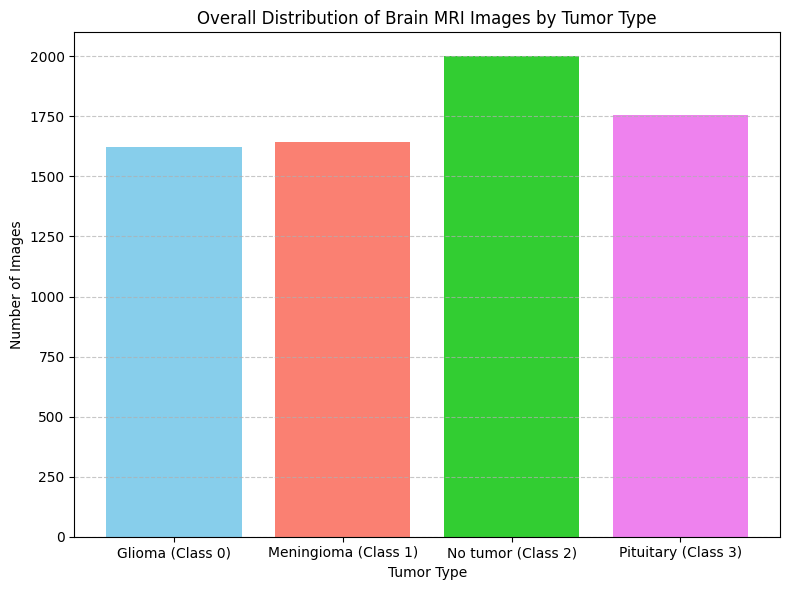

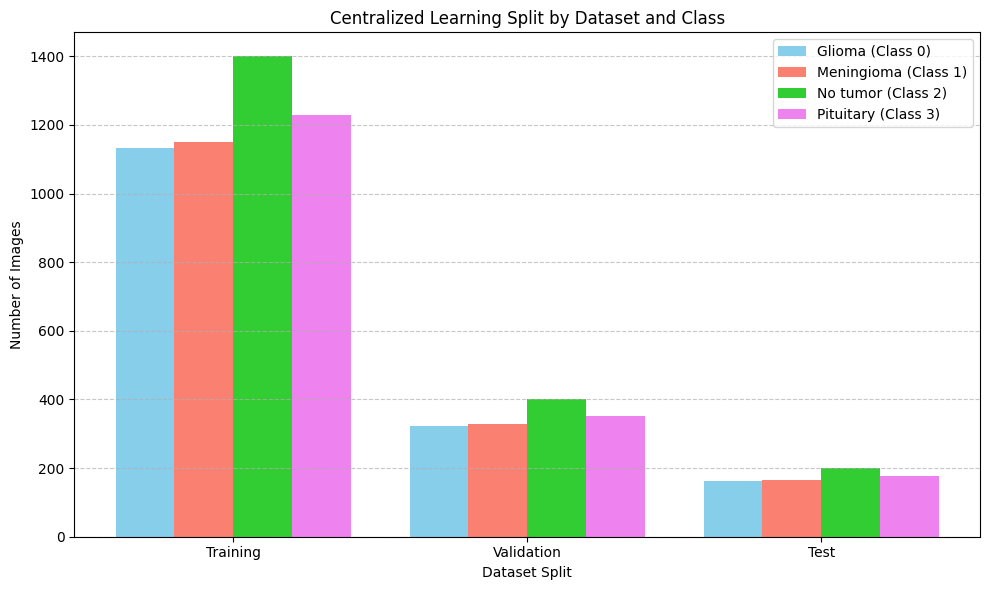

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ---------------------------
# Visualization for Overall Dataset Distribution (Figure~\ref{fig:data_distribution})
# ---------------------------

# Correct class names and their overall counts
classes = ['Glioma (Class 0)', 'Meningioma (Class 1)', 'No tumor (Class 2)', 'Pituitary (Class 3)']
overall_counts = [1621, 1645, 2000, 1757]

# Create bar chart for overall distribution
plt.figure(figsize=(8, 6))
bars = plt.bar(classes, overall_counts, color=['skyblue', 'salmon', 'limegreen', 'violet'])
plt.title('Overall Distribution of Brain MRI Images by Tumor Type')
plt.xlabel('Tumor Type')
plt.ylabel('Number of Images')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
# Uncomment the next line to save the figure for your LaTeX document
# plt.savefig('data-distr.png', dpi=300, bbox_inches='tight')
plt.show()

# ---------------------------
# Visualization for Centralized Learning Split (Figure~\ref{fig:centr_lr})
# ---------------------------

# Correct data for the centralized learning split
split_names = ['Training', 'Validation', 'Test']
data = {
    'Glioma (Class 0)': [1134, 324, 163],
    'Meningioma (Class 1)': [1151, 329, 165],
    'No tumor (Class 2)': [1400, 400, 200],
    'Pituitary (Class 3)': [1229, 351, 177]
}

# Create a DataFrame for easier plotting
df = pd.DataFrame(data, index=split_names)

# Set up positions for grouped bars
x = np.arange(len(split_names))  # Label locations
width = 0.2  # Width of each bar

# Create the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars0 = ax.bar(x - 1.5 * width, df['Glioma (Class 0)'], width, label='Glioma (Class 0)', color='skyblue')
bars1 = ax.bar(x - 0.5 * width, df['Meningioma (Class 1)'], width, label='Meningioma (Class 1)', color='salmon')
bars2 = ax.bar(x + 0.5 * width, df['No tumor (Class 2)'], width, label='No tumor (Class 2)', color='limegreen')
bars3 = ax.bar(x + 1.5 * width, df['Pituitary (Class 3)'], width, label='Pituitary (Class 3)', color='violet')

# Customize the plot
ax.set_title('Centralized Learning Split by Dataset and Class')
ax.set_xlabel('Dataset Split')
ax.set_ylabel('Number of Images')
ax.set_xticks(x)
ax.set_xticklabels(split_names)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
# Uncomment the next line to save the figure for your LaTeX document
# plt.savefig('centr-lr.png', dpi=300, bbox_inches='tight')
plt.show()

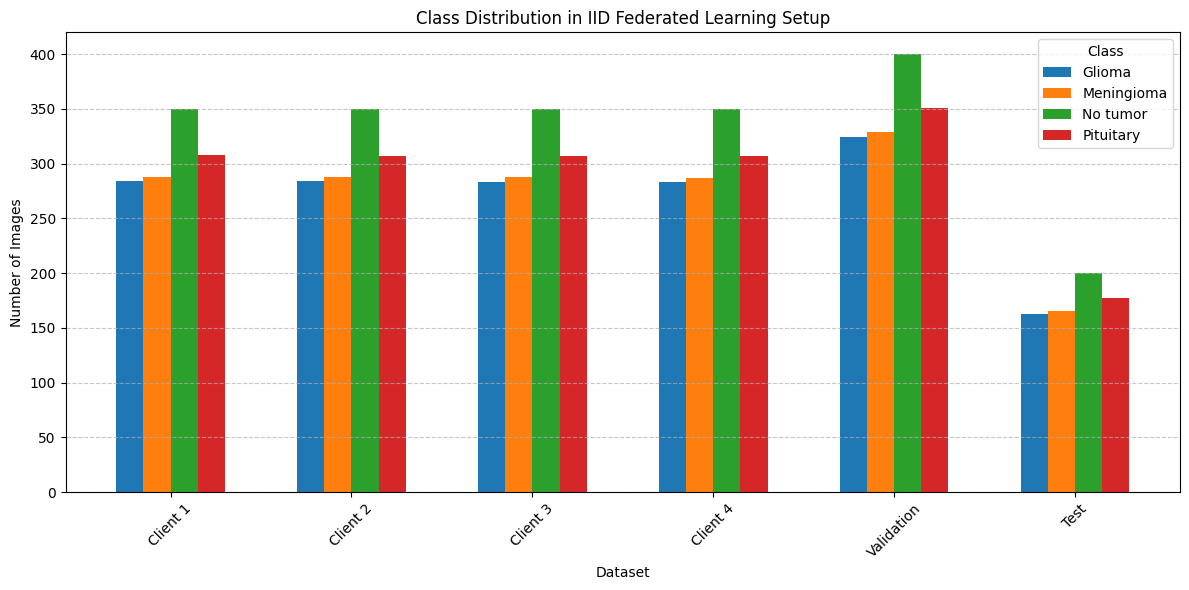

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the query
datasets = ['Client 1', 'Client 2', 'Client 3', 'Client 4', 'Validation', 'Test']
classes = ['Glioma', 'Meningioma', 'No tumor', 'Pituitary']
data = [
    [284, 288, 350, 308],  # Client 1
    [284, 288, 350, 307],  # Client 2
    [283, 288, 350, 307],  # Client 3
    [283, 287, 350, 307],  # Client 4
    [324, 329, 400, 351],  # Validation
    [163, 165, 200, 177]   # Test
]

# Set up the figure
fig, ax = plt.subplots(figsize=(12, 6))

# Bar width and positions
bar_width = 0.15
x = np.arange(len(datasets))

# Plot bars for each class
for i, class_name in enumerate(classes):
    class_counts = [d[i] for d in data]
    ax.bar(x + i * bar_width, class_counts, width=bar_width, label=class_name)

# Customize the plot
ax.set_title('Class Distribution in IID Federated Learning Setup')
ax.set_xlabel('Dataset')
ax.set_ylabel('Number of Images')
ax.set_xticks(x + bar_width * 1.5)
ax.set_xticklabels(datasets, rotation=45)
ax.legend(title='Class')
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
# Uncomment to save for LaTeX inclusion
# plt.savefig('iid_distribution.png', dpi=300, bbox_inches='tight')
plt.show()